In [2]:
rm(list=ls())
libraries = c("dplyr","magrittr","tidyr","reshape2","ggplot2","ggpubr","hrbrthemes","extrafont","openxlsx","readxl","RColorBrewer","zoo",
              "readxl","writexl","gridExtra","MASS","readr","stats","boot","pracma","stringr","mixdist","corpcor","rstan","bayesplot")
for(x in libraries) { library(x,character.only=TRUE,warn.conflicts=FALSE,quietly=TRUE) }

theme_set(theme_bw())
setwd("../wane_ve_estimation_multivariant")

In [3]:
voc <- read_csv("data/VOC_simulation.csv") 
voc$week <- as.Date(voc$week)
voc %<>% mutate(Variant_type = recode(Variant, Others = "Variant A", Alpha = "Variant B", Delta = "Variant C", Omicron = "Variant D"))
voc %>% head(5);voc %>% tail(5)
A <- voc %>% filter(Variant_type == "Variant A")
B <- voc %>% filter(Variant_type == "Variant B")
C <- voc %>% filter(Variant_type == "Variant C")
D <- voc %>% filter(Variant_type == "Variant D")

Parsed with column specification:
cols(
  week = col_character(),
  Proportion = col_double(),
  Variant = col_character()
)



week,Proportion,Variant,Variant_type
<date>,<dbl>,<chr>,<chr>
2020-12-30,0,Alpha,Variant B
2021-01-03,0,Alpha,Variant B
2021-01-10,0,Alpha,Variant B
2021-01-17,0,Alpha,Variant B
2021-01-24,0,Alpha,Variant B


week,Proportion,Variant,Variant_type
<date>,<dbl>,<chr>,<chr>
2022-04-17,0.000,Others,Variant A
2022-04-24,0.008,Others,Variant A
2022-05-01,0.000,Others,Variant A
2022-05-08,0.000,Others,Variant A
2022-05-15,0.000,Others,Variant A


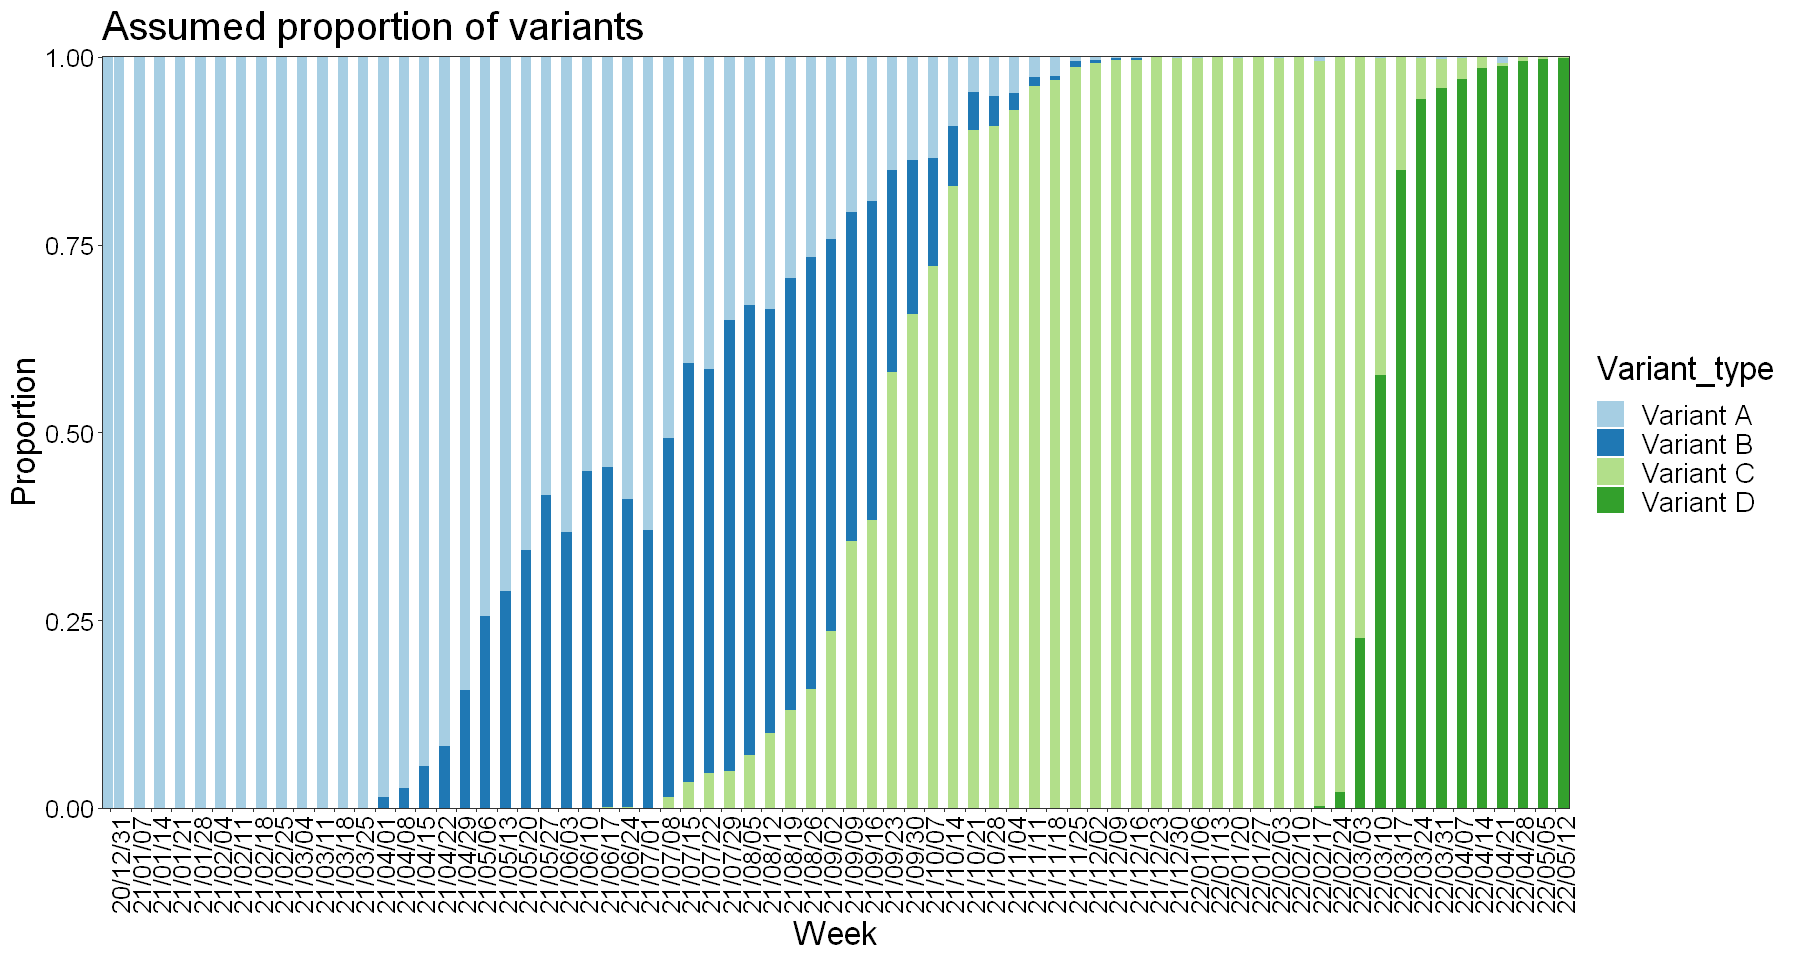

In [4]:
options(repr.plot.width=15,repr.plot.height=8)
voc %>% ggplot() +
  geom_bar(aes(x=week,y=Proportion, fill=Variant_type), stat = "identity") +
  scale_x_date(date_labels = "%y/%m/%d", date_breaks = "7 day", expand = c(0,0)) +
  scale_y_continuous(expand = c(0,0))+
  labs(x="Week", y="Proportion") +
  ggtitle("Assumed proportion of variants") +
  theme_bw() + theme(axis.text.x = element_text(size=15, angle = 90, hjust = 1),axis.text.y = element_text(size=15)) + scale_fill_brewer(palette = "Paired") + 
    theme(text = element_text(size=20, family="sans",color="black"),
          axis.text = element_text(size=10, family="sans",color="black"),
          panel.grid.major = element_blank(), panel.grid.minor = element_blank()) 

In [5]:
ncov_vax <- read_csv("data/vax_rollout_simulation.csv") 
ncov_vax$week <- as.Date(ncov_vax$week)
ncov_vax%>%head(5);ncov_vax%>%tail(5)

Parsed with column specification:
cols(
  week = col_character(),
  vaccine = col_double(),
  cumulative = col_double()
)



week,vaccine,cumulative
<date>,<dbl>,<dbl>
2020-12-30,14532,358776
2021-01-03,14783,373559
2021-01-10,17431,390990
2021-01-17,31970,422960
2021-01-24,97021,519981


week,vaccine,cumulative
<date>,<dbl>,<dbl>
2022-04-17,12448,12586925
2022-04-24,11167,12598092
2022-05-01,13168,12611260
2022-05-08,9513,12620773
2022-05-15,13262,12634035


### Scenario 1

In [6]:
### ve basic function
basicfn <- function(p,k,t){
    fn <-  p*(1/(exp(k*(t-1)) + 1))
    return(fn)
}

ve_others <- function(t){
    fn <- basicfn(p=0.95*2,k=0.01,t) #0.002
    return(fn)
}
ve_alpha <- function(t){
    fn <- basicfn(p=0.90*2,k=0.005,t) #0.005
    return(fn)
}
ve_delta <- function(t){
    fn <- basicfn(p=0.85*2,k=0.03,t) #0.012
    return(fn)
}
ve_omicron <- function(t){
    fn <- basicfn(p=0.95*2,k=0.01,t)
    return(fn)
}

[1] 0.8500000 0.8372510 0.8245076 0.8117758 0.7990611 0.7863693 0.7737059
 [8] 0.7610766 0.7484868 0.7359421 0.7234477 0.7110091 0.6986313 0.6863194
[15] 0.6740785 0.6619133 0.6498286 0.6378290 0.6259189 0.6141026 0.6023843
[22] 0.5907679 0.5792573 0.5678562 0.5565681 0.5453962 0.5343438 0.5234138
[29] 0.5126091 0.5019323 0.4913858 0.4809720 0.4706929 0.4605505 0.4505466
[36] 0.4406827 0.4309602 0.4213805 0.4119446 0.4026535 0.3935079 0.3845084
[43] 0.3756556 0.3669498 0.3583911 0.3499796 0.3417153 0.3335979 0.3256271
[50] 0.3178024 0.3101234 0.3025893 0.2951993 0.2879526 0.2808483 0.2738852
[57] 0.2670623 0.2603783 0.2538320 0.2474220

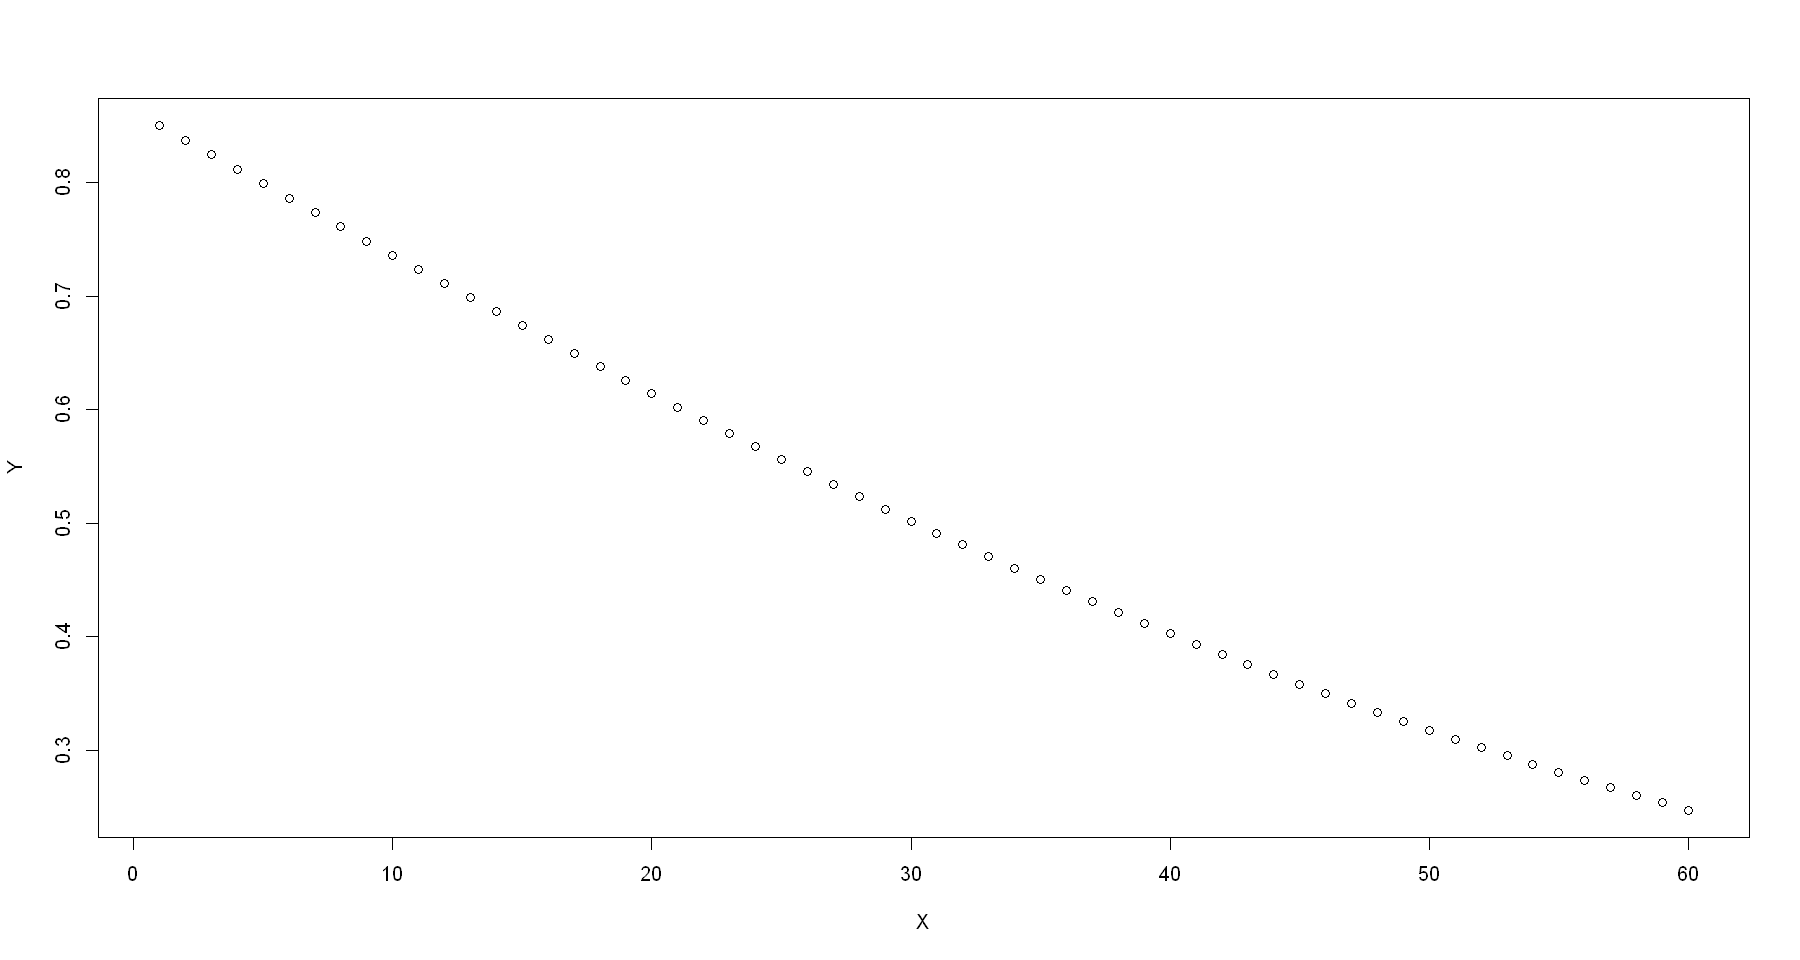

In [35]:
### check ve function
options(repr.plot.width=15,repr.plot.height=8)
X <- seq(1,60,1)
Y <- rep(0,60)
for(i in 1:60){Y[i] <- ve_delta(i)}
Y
plot(X,Y)

### simulation code

In [7]:
set.seed(12345)
T=nrow(A);
l = 2; 
N = 14826276;
Ri = rep(0,T-l); Rj = rep(0,T-l); 
i0 <- c(3300,3200); j0 <- c(0,3); 
eta <- 300
Ci <- rep(0,T-l)
Cj <- rep(0,T-l)
zeta <- rep(0,T-l)
eps <- rep(0,T-l)
rollout <- ncov_vax$cumulative
rollout1 <- ncov_vax$vaccine/N
se <- 0.1
GT <- function(t){plnorm(t*7, log(4.699), log(2.936))-plnorm(t*7-7, log(4.699), log(2.936))}   
it <- rep(0, T); jt <- rep(0, T);
iit <- c(i0,rep(0, T-l)); jjt <- c(j0,rep(0, T-l));

for(t in (1+l):T){
    fn_overall <- rep(0,t)
    for(tt in 1:t){
        fn_overall[tt] <- (A$Proportion[t] * ve_others(t-tt+1) +B$Proportion[t] * ve_alpha(t-tt+1) + C$Proportion[t] * ve_delta(t-tt+1) + D$Proportion[t] * ve_omicron(t-tt+1)) * rollout1[tt] 
    }   
    zeta[t-l] <- sum(fn_overall[1:t])
    eps[t-l] <- rbeta(1, shape1 = zeta[t-l] * eta/sqrt(jt[t-1]+1e-4), shape2 = eta/sqrt(jt[t-1]+1e-4) - zeta[t-l] * eta/sqrt(jt[t-1]+1e-4))
    
    
    Ri[t-l] <- exp(rnorm(1,log(0.5*A$Proportion[t] + 0.5*1.5*B$Proportion[t] + 0.3*0.5*1.5*1.2*C$Proportion[t] + 0.3*0.5*1.5*1.2*0.6*D$Proportion[t]),se))#exp(rnorm(1,log(0.5),se))
    Rj[t-l] <- (1-eps[t-l]) * (rollout[t]/(N-rollout[t])) * Ri[t-l] 
    
    for (tau in 2:t){it[tau-1] = Ri[t-l] * (iit[t-tau+1] + jjt[t-tau+1]) * GT(tau-1)}
    for (tau in 2:t){jt[tau-1] = Rj[t-l] * (iit[t-tau+1] + jjt[t-tau+1]) * GT(tau-1)} 
    
    iit[t] = rpois(1,sum(it[1:(t-1)])) 
    jjt[t] = rpois(1,sum(jt[1:(t-1)]))
}
llk <- rep(0,T-l)
for(t in (l+1):(T)){
    for (tau in 2:t){it[tau-1] = Ri[t-l] * (iit[t-tau+1] + jjt[t-tau+1]) * GT(tau-1)}
    for (tau in 2:t){jt[tau-1] = Rj[t-l] * (iit[t-tau+1] + jjt[t-tau+1]) * GT(tau-1)} 
    llk[t-l] = dpois(iit[t],sum(it[(1):(t-1)]),log=TRUE) + dpois(jjt[t],sum(jt[(1):(t-1)]),log=TRUE) + dbeta(eps[t-l],shape1 = zeta[t-l] * eta/sqrt(jt[t]+1e-4), shape2 = eta/sqrt(jt[t]+1e-4) - zeta[t-l] * eta/sqrt(jt[t]+1e-4),log=TRUE)
}

weeks <- as.data.frame(c(ncov_vax$week,ncov_vax$week))
case <- as.data.frame(c(iit,jjt))
Type <- as.data.frame(c(rep("Unvaccinated",T),rep("Vaccinated",T)))
df <- cbind(weeks,Type,case)
df <- as.data.frame(df)
colnames(df) <- c("Week","Type","Case")
df$Week <- as.Date(df$Week)
iit;jjt

[1] 3300 3200 1458  745  557  347  319  239  179  169  125   71   78   76   64
[16]   61   58   53   54   67   96   98  118  125  156  187  187  220  283  360
[31]  397  478  779  713  824  912 1105 1149 1246 1486 1772 1806 1605 1808 1901
[46] 1553 1518 1686 1512 1548 1441 1241 1600 1675 1904 1918 2470 2798 3333 3741
[61] 4638 4818 4866 4788 3167 2161 1727 1128 1079  810  588  517  350

[1]     0     3    39    22    18    16    16    22    44    49    41    39
[13]    49    57    52    52    50    37    41    61    93    93    89   118
[25]   164   174   215   236   283   373   427   615   941   908  1066  1198
[37]  1520  1761  1999  2683  3371  3772  3561  4328  4701  3764  4041  4313
[49]  4191  4417  4109  3517  4947  5306  6236  6270  7951  9237 11207 12699
[61] 16169 17076 16115 13504  7828  4966  4081  2537  2377  1876  1289  1228
[73]   739

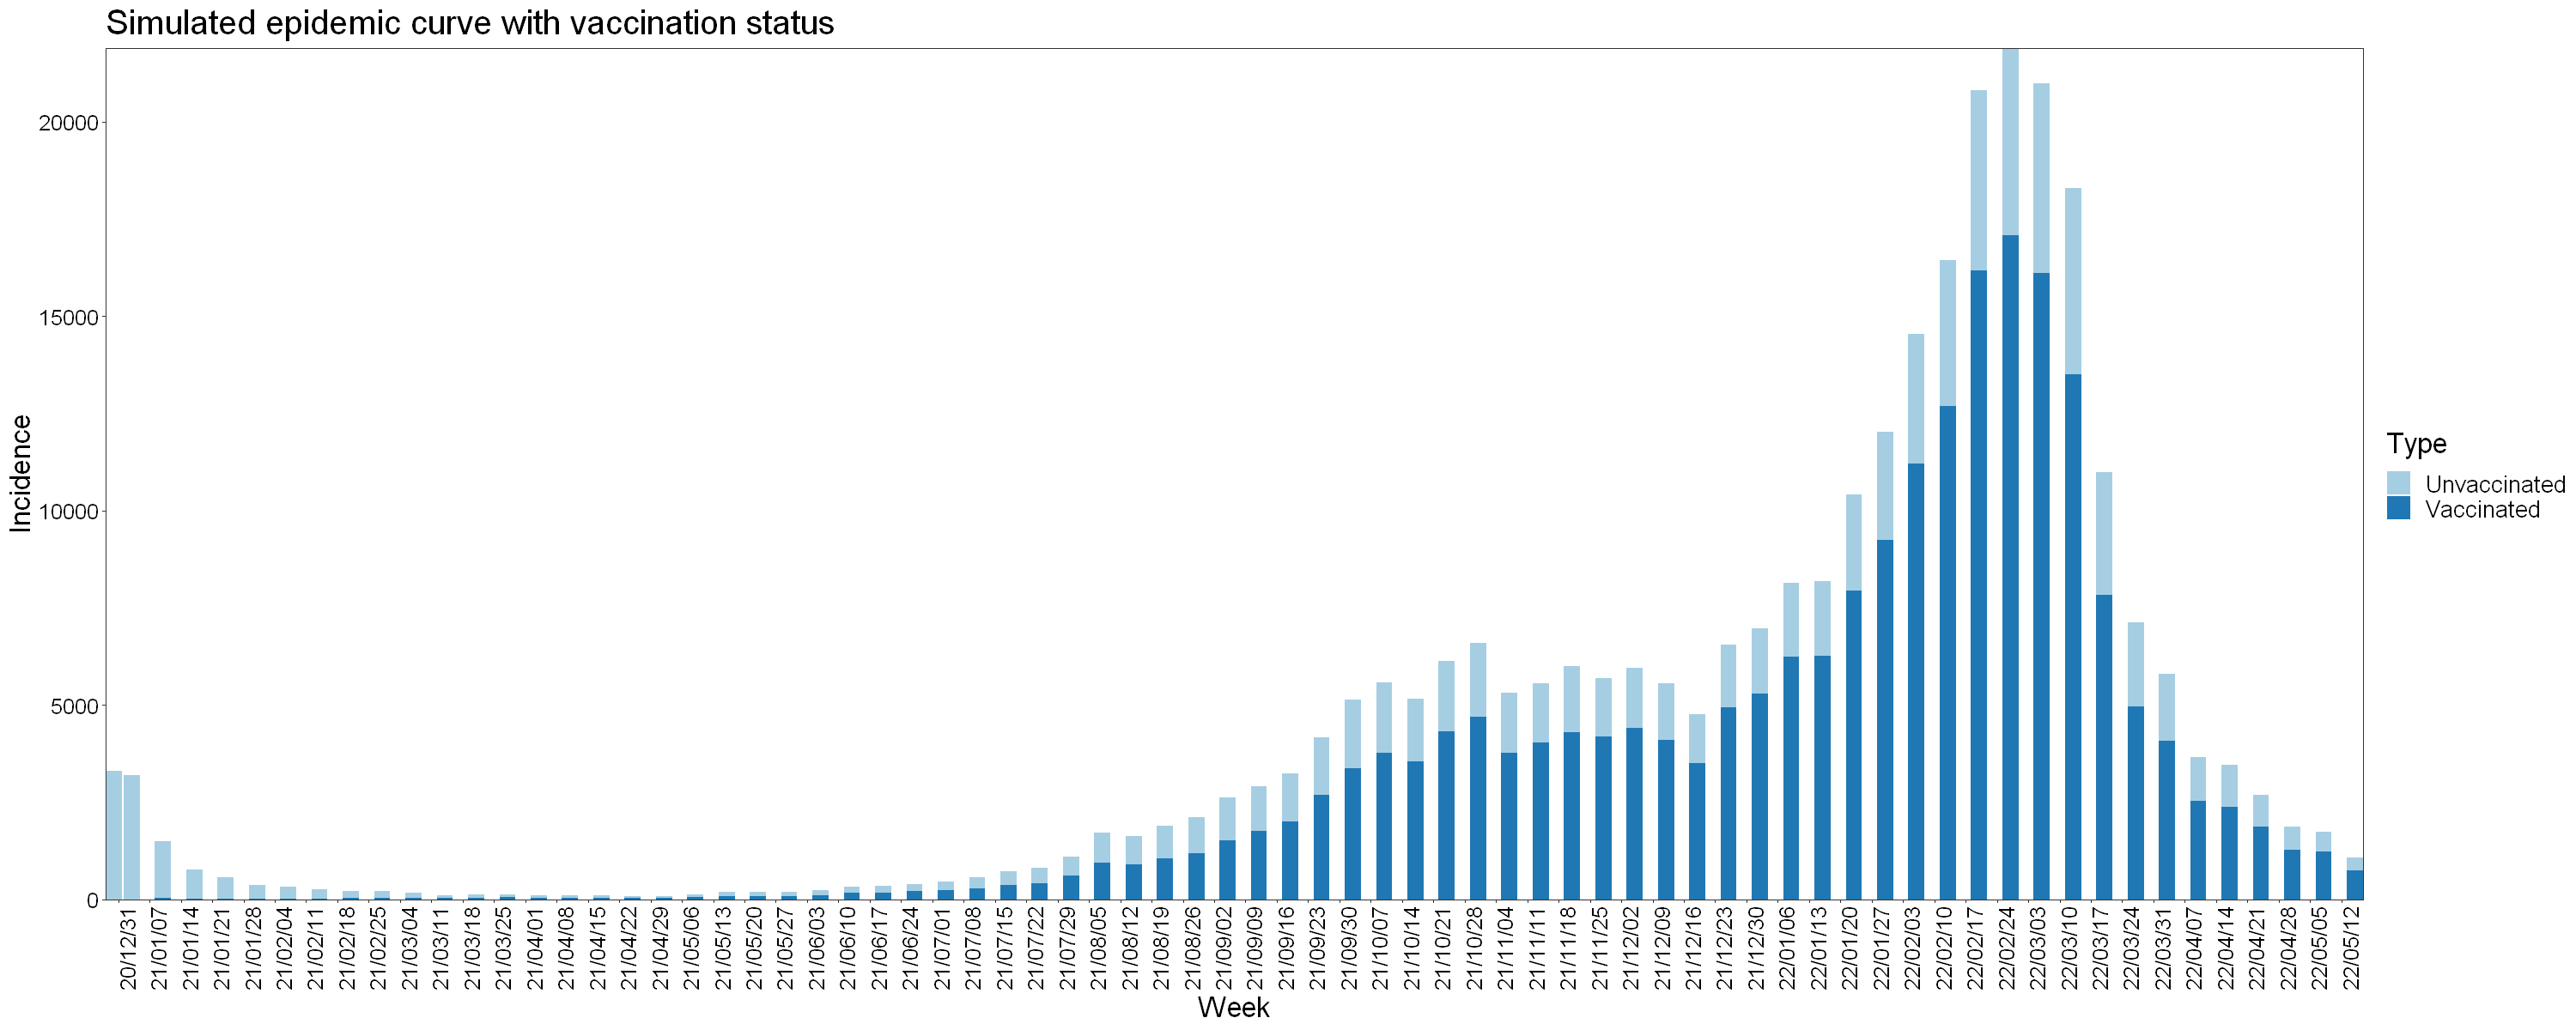

In [8]:
options(repr.plot.width=25,repr.plot.height=10)
df %>% ggplot() +
  geom_bar(aes(x=Week,y=Case, fill=Type), stat = "identity") +
  scale_x_date(date_labels = "%y/%m/%d", date_breaks = "7 day", expand = c(0,0)) +
  scale_y_continuous(expand = c(0,0))+
  labs(x="Week", y="Incidence") +
  ggtitle("Simulated epidemic curve with vaccination status") + scale_fill_brewer(palette = "Paired") +
  theme_bw() + theme(axis.text.x = element_text(size=15, angle = 90, hjust = 1),axis.text.y = element_text(size=15)) +
    theme(text = element_text(size=20, family="sans",color="black"),
          axis.text = element_text(size=10, family="sans",color="black"),
          panel.grid.major = element_blank(), panel.grid.minor = element_blank())


### stan code

In [9]:
source("src/stan/Model_Simulation_param.stan") # load functions
#source("src/stan/Model_Simulation_spline.stan")
#options(jupyter.plot_mimetypes = "image/svg+xml")

In [10]:
It <- df %>% filter(Type=="Unvaccinated") 
Jt <- df %>% filter(Type=="Vaccinated") 

In [11]:
## modify data into a form suitable for Stan
delay=0
l=2 # adjustment for left censoring
m=0 # control the end of observation period 
T = nrow(A)-l-m # number of days
N = 14826276
num_data = T+l+delay
it = It$Case
jt = Jt$Case
vA = A$Proportion[1:(T+l+delay)]
vB = B$Proportion[1:(T+l+delay)]
vC = C$Proportion[1:(T+l+delay)]
vD = D$Proportion[1:(T+l+delay)]
vaccine= ncov_vax$vaccine[1:(T+l+delay)]/N
odds = ncov_vax$cumulative[1:(T+l+delay)]/(N-ncov_vax$cumulative[1:(T+l+delay)])
si = plnorm(seq(7, (T+l)*7, by = 7), log(4.699), log(2.936))-plnorm(seq(0, (T+l)*7-7, by = 7), log(4.699), log(2.936)) #serial interval (Nishiura et al. 2020)

data = list(T=T, N=N, it=it, jt=jt, Gamma=vaccine, SI=si, odds=odds, vA=vA, vB=vB, vC=vC, vD=vD, delay=delay, l=l, num_data=num_data)
# specify parameters to monitor
parameters = c("ve_o","ve_a","ve_d","ve_om","zeta","eta","Rit","Rjt","k","p","ii","jj")
# eps: overall effect over time, ve: direct effect over time


nuts_fit1 = stan(model_code=Model,data=data,pars=parameters,iter=5000,thin=1,warmup=1000,chain=2)


SAMPLING FOR MODEL 'a7a3656ae6c53bebbfb28ce25440dd52' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.006 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 60 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 5000 [  0%]  (Warmup)
Chain 1: Iteration:  500 / 5000 [ 10%]  (Warmup)
Chain 1: Iteration: 1000 / 5000 [ 20%]  (Warmup)
Chain 1: Iteration: 1001 / 5000 [ 20%]  (Sampling)
Chain 1: Iteration: 1500 / 5000 [ 30%]  (Sampling)
Chain 1: Iteration: 2000 / 5000 [ 40%]  (Sampling)
Chain 1: Iteration: 2500 / 5000 [ 50%]  (Sampling)
Chain 1: Iteration: 3000 / 5000 [ 60%]  (Sampling)
Chain 1: Iteration: 3500 / 5000 [ 70%]  (Sampling)
Chain 1: Iteration: 4000 / 5000 [ 80%]  (Sampling)
Chain 1: Iteration: 4500 / 5000 [ 90%]  (Sampling)
Chain 1: Iteration: 5000 / 5000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 255.524 seconds (Warm-up)
Chain 1:                419.655 seconds (Sampling)


In [12]:
nuts_fit1

Inference for Stan model: a7a3656ae6c53bebbfb28ce25440dd52.
2 chains, each with iter=5000; warmup=1000; thin=1; 
post-warmup draws per chain=4000, total post-warmup draws=8000.

              mean se_mean     sd     2.5%      25%      50%      75%    97.5%
ve_o[1]       0.87    0.00   0.06     0.75     0.83     0.87     0.91     0.98
ve_o[2]       0.86    0.00   0.06     0.75     0.83     0.87     0.91     0.97
ve_o[3]       0.86    0.00   0.06     0.75     0.82     0.86     0.90     0.96
ve_o[4]       0.86    0.00   0.05     0.75     0.82     0.86     0.89     0.96
ve_o[5]       0.85    0.00   0.05     0.74     0.82     0.85     0.89     0.95
ve_o[6]       0.85    0.00   0.05     0.74     0.81     0.85     0.88     0.94
ve_o[7]       0.84    0.00   0.05     0.74     0.81     0.84     0.88     0.94
ve_o[8]       0.84    0.00   0.05     0.73     0.80     0.84     0.87     0.94
ve_o[9]       0.83    0.00   0.05     0.73     0.80     0.83     0.87     0.93
ve_o[10]      0.83    0.00   0.0

In [40]:
## modify data into a form suitable for Stan
delay=0
l=2 # adjustment for left censoring
m=0 # control the end of observation period 
T = nrow(A)-l-m # number of days
N = 14826276
num_data = T+l+delay
X = seq(1, num_data, by=1)
xknots = c(1, 40,num_data)
nknots = length(xknots)
it = It$Case
jt = Jt$Case
vA = A$Proportion[1:(T+l+delay)]
vB = B$Proportion[1:(T+l+delay)]
vC = C$Proportion[1:(T+l+delay)]
vD = D$Proportion[1:(T+l+delay)]
vaccine= ncov_vax$vaccine[1:(T+l+delay)]/N
odds = ncov_vax$cumulative[1:(T+l+delay)]/(N-ncov_vax$cumulative[1:(T+l+delay)])
si = plnorm(seq(7, (T+l)*7, by = 7), log(4.699), log(2.936))-plnorm(seq(0, (T+l)*7-7, by = 7), log(4.699), log(2.936)) #serial interval (Nishiura et al. 2020)

data = list(T=T, N=N, it=it, jt=jt, Gamma=vaccine, SI=si, odds=odds, vA=vA, vB=vB, vC=vC, vD=vD, delay=delay, l=l, num_data=num_data, X=X, xknots=xknots,nknots=nknots)
# specify parameters to monitor
parameters = c("ve_o","ve_a","ve_d","ve_om","zeta","eta","Rit","Rjt","log_lik","ii","jj")
# eps: overall effect over time, ve: direct effect over time
#init = list(c("eta[1]"=100,"yknots_o[1]"=logit(ve_others(1)),"yknots_a[1]"=logit(ve_alpha(1)),"yknots_d[1]"=logit(ve_delta(1)),"yknots_om[1]"=logit(ve_omicron(1)),"yknots_o[2]"=logit(ve_others(40)),"yknots_a[2]"=logit(ve_alpha(40)),"yknots_d[2]"=logit(ve_delta(40)),"yknots_om[2]"=logit(ve_omicron(40)),"yknots_o[3]"=logit(ve_others(num_data)),"yknots_a[3]"=logit(ve_alpha(num_data)),"yknots_d[3]"=logit(ve_delta(num_data)),"yknots_om[3]"=logit(ve_omicron(num_data))))
nuts_fit1 = stan(model_code=Model_1,data=data,pars=parameters,iter=5000,thin=1,warmup=100,chain=2)


SAMPLING FOR MODEL '4429c94d7eae381b504eeea959ebcf37' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.003 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 30 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: WARNING: There aren't enough warmup iterations to fit the
Chain 1:          three stages of adaptation as currently configured.
Chain 1:          Reducing each adaptation stage to 15%/75%/10% of
Chain 1:          the given number of warmup iterations:
Chain 1:            init_buffer = 15
Chain 1:            adapt_window = 75
Chain 1:            term_buffer = 10
Chain 1: 
Chain 1: Iteration:    1 / 5000 [  0%]  (Warmup)
Chain 1: Iteration:  101 / 5000 [  2%]  (Sampling)
Chain 1: Iteration:  600 / 5000 [ 12%]  (Sampling)
Chain 1: Iteration: 1100 / 5000 [ 22%]  (Sampling)
Chain 1: Iteration: 1600 / 5000 [ 32%]  (Sampling)
Chain 1: Iteration: 2100 / 5000 [ 42%]  (Sampling)
Chain 1: Iteration: 2600 / 500

Warning message:
"There were 6426 transitions after warmup that exceeded the maximum treedepth. Increase max_treedepth above 10. See
http://mc-stan.org/misc/warnings.html#maximum-treedepth-exceeded"
Warning message:
"Examine the pairs() plot to diagnose sampling problems
"


### plot

In [17]:
source("src/plot/Result_arrangement.R") # load functions
#options(jupyter.plot_mimetypes = "image/svg+xml")

In [18]:
source("src/plot/Plot_simulation.R") # load functions
#options(jupyter.plot_mimetypes = "image/svg+xml")

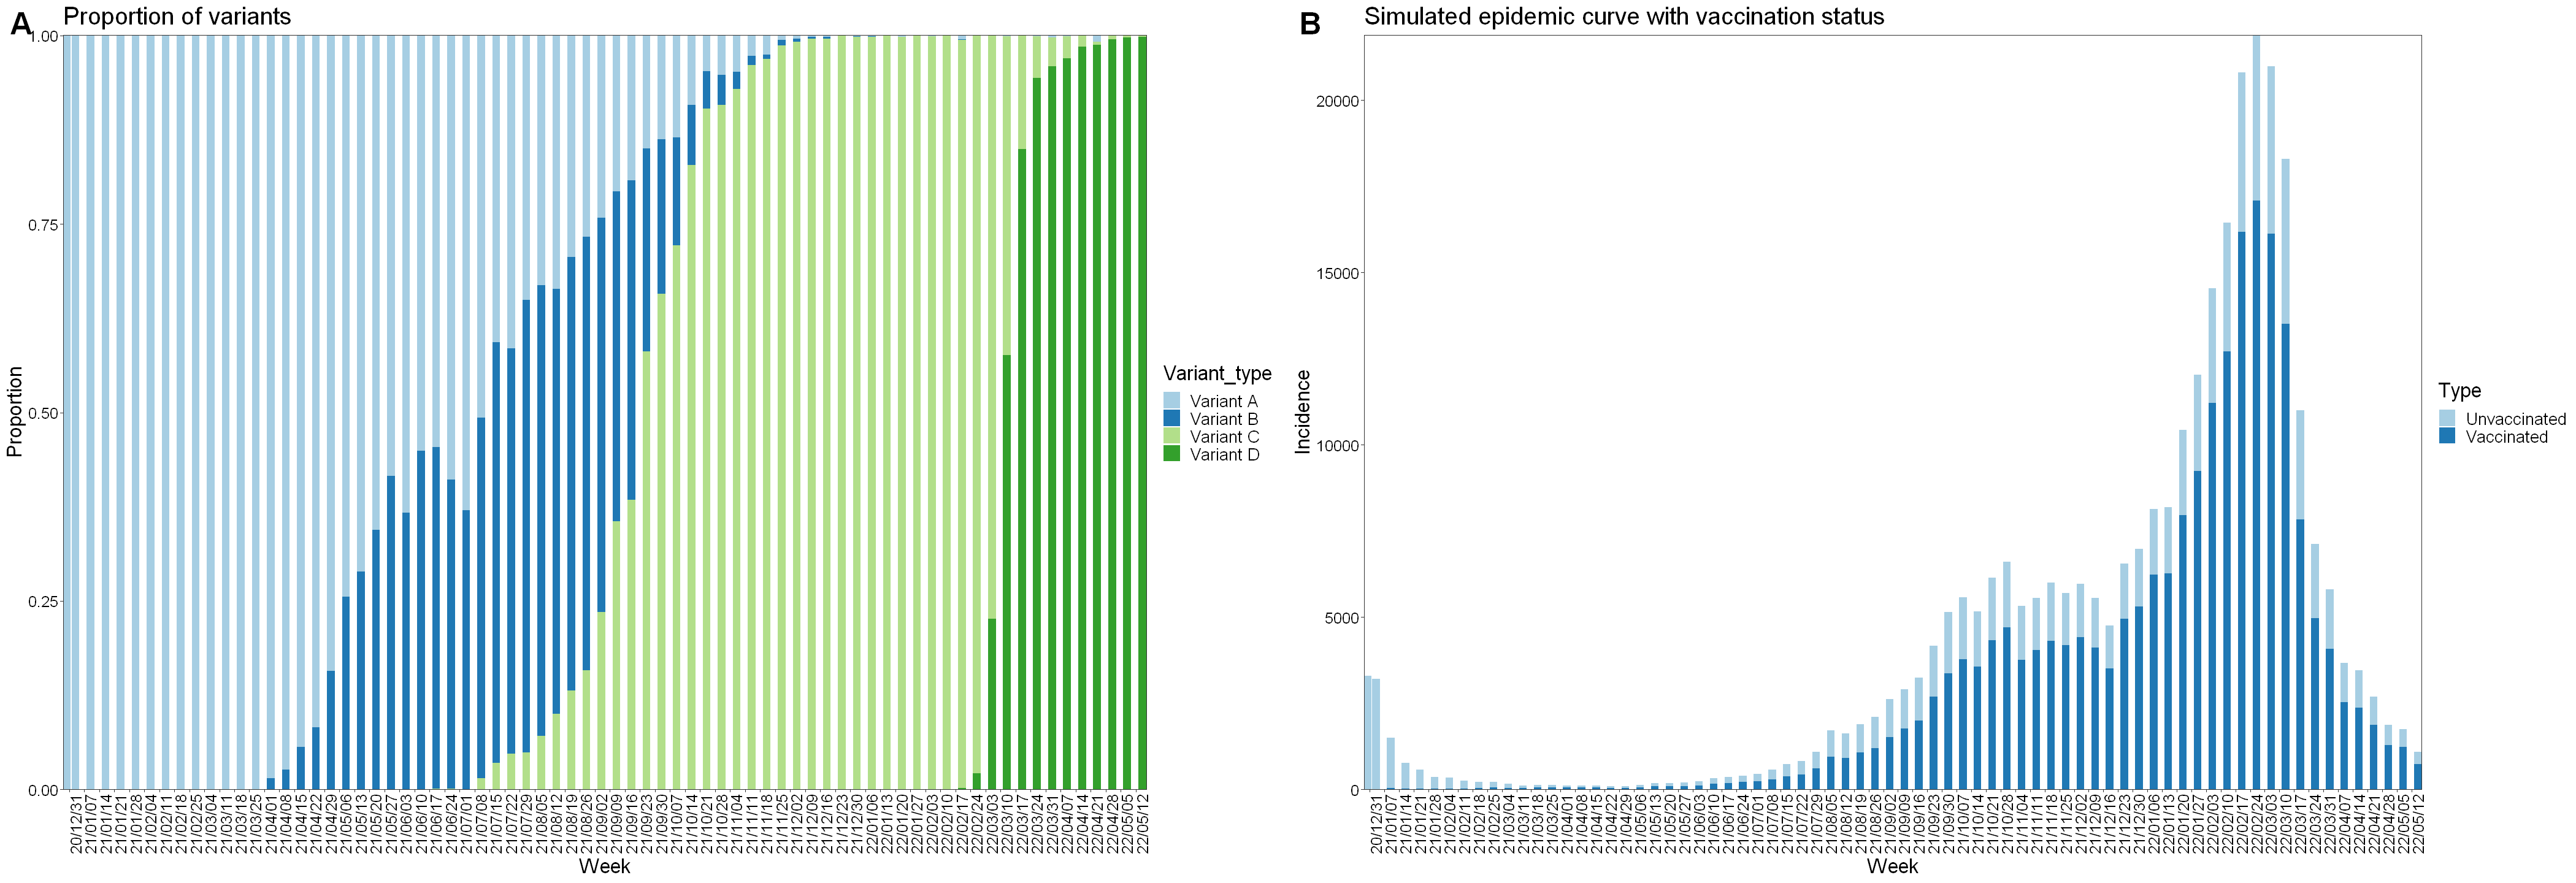

In [23]:
options(repr.plot.width=35,repr.plot.height=12)
ggarrange(voc_plot, case_simulation, nrow=1,ncol=2,font.label=list(size=30),labels=c("A","B"),legend="right")
ggsave(file = "output/simulation_data.png", width = 35, height = 12)

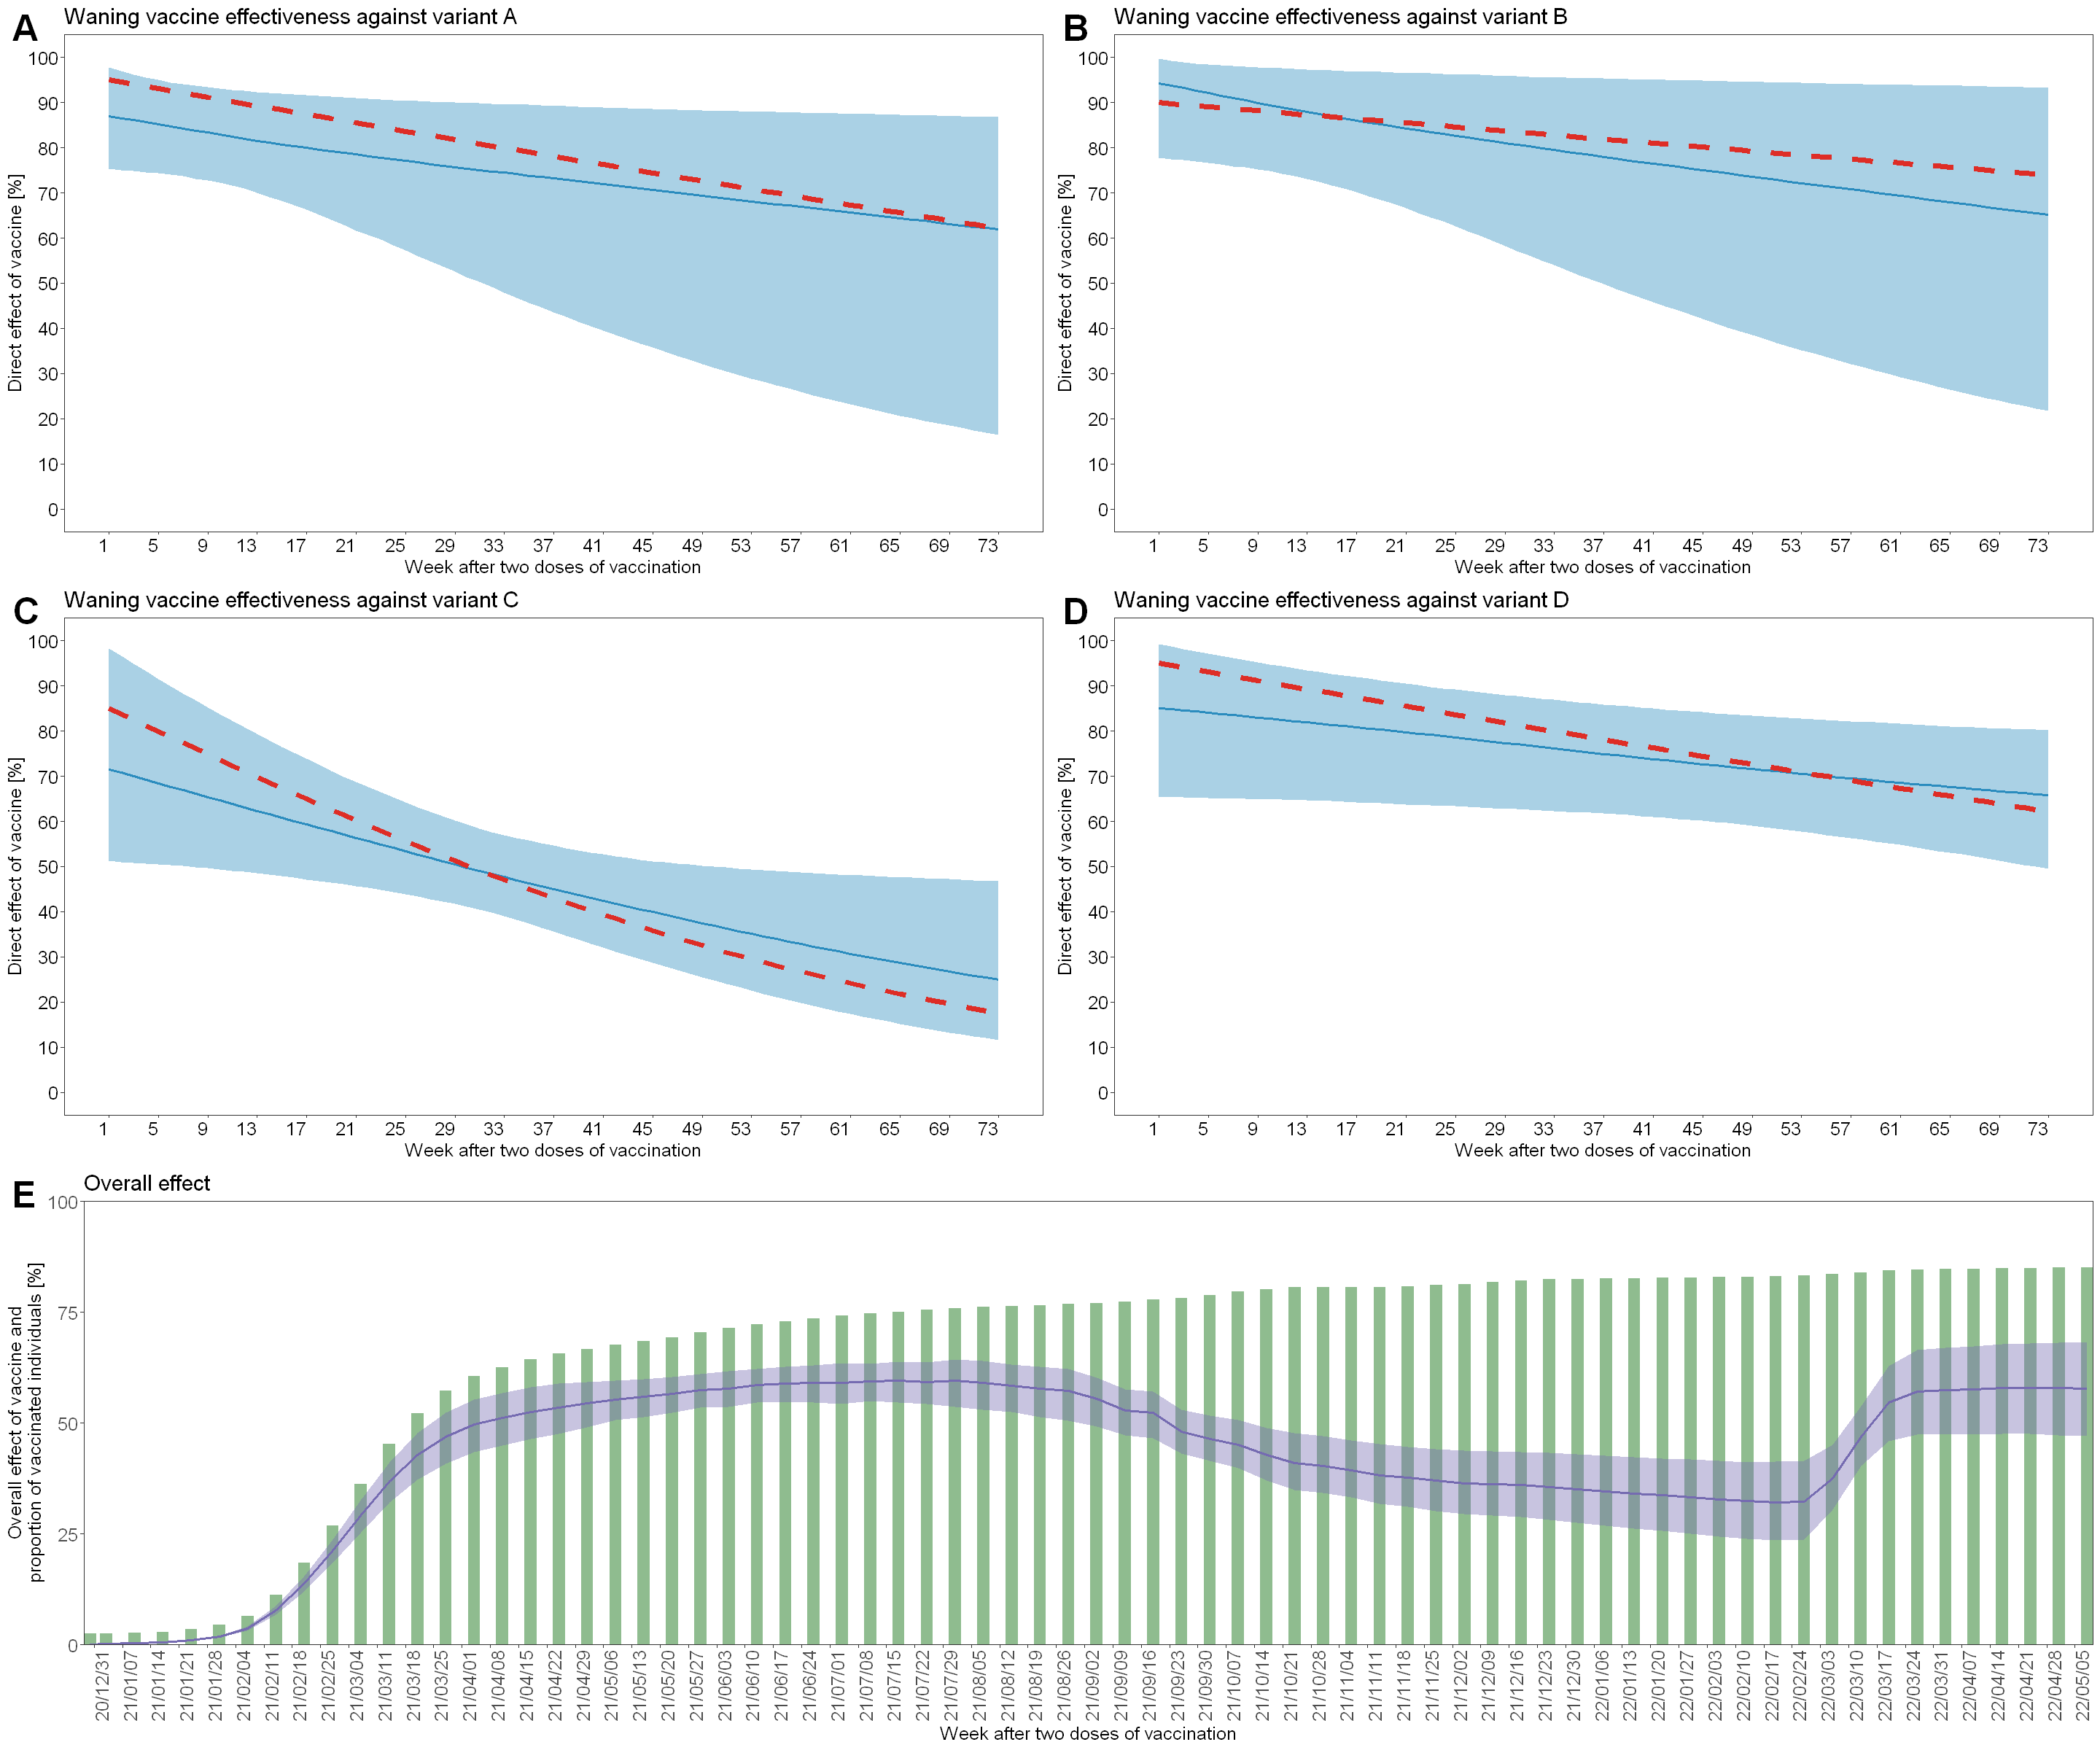

In [15]:
options(repr.plot.width=24,repr.plot.height=20)
direct_effect1 <- ggarrange(delta_plot, omicron_plot, nrow=1,ncol=2,labels=c("C","D"),font.label=list(size=30),common.legend=TRUE,legend="right")
direct_effect2 <- ggarrange(others_plot,alpha_plot, nrow=1,ncol=2,labels=c("A","B"),font.label=list(size=30),common.legend=TRUE,legend="right")
ggarrange(direct_effect2, direct_effect1, overall_plot, nrow=3,ncol=1,font.label=list(size=30),labels=c("","","E"),legend="right")

ggsave(file = "output/VE_waning_simulation1_param.png", width = 24, height = 20)

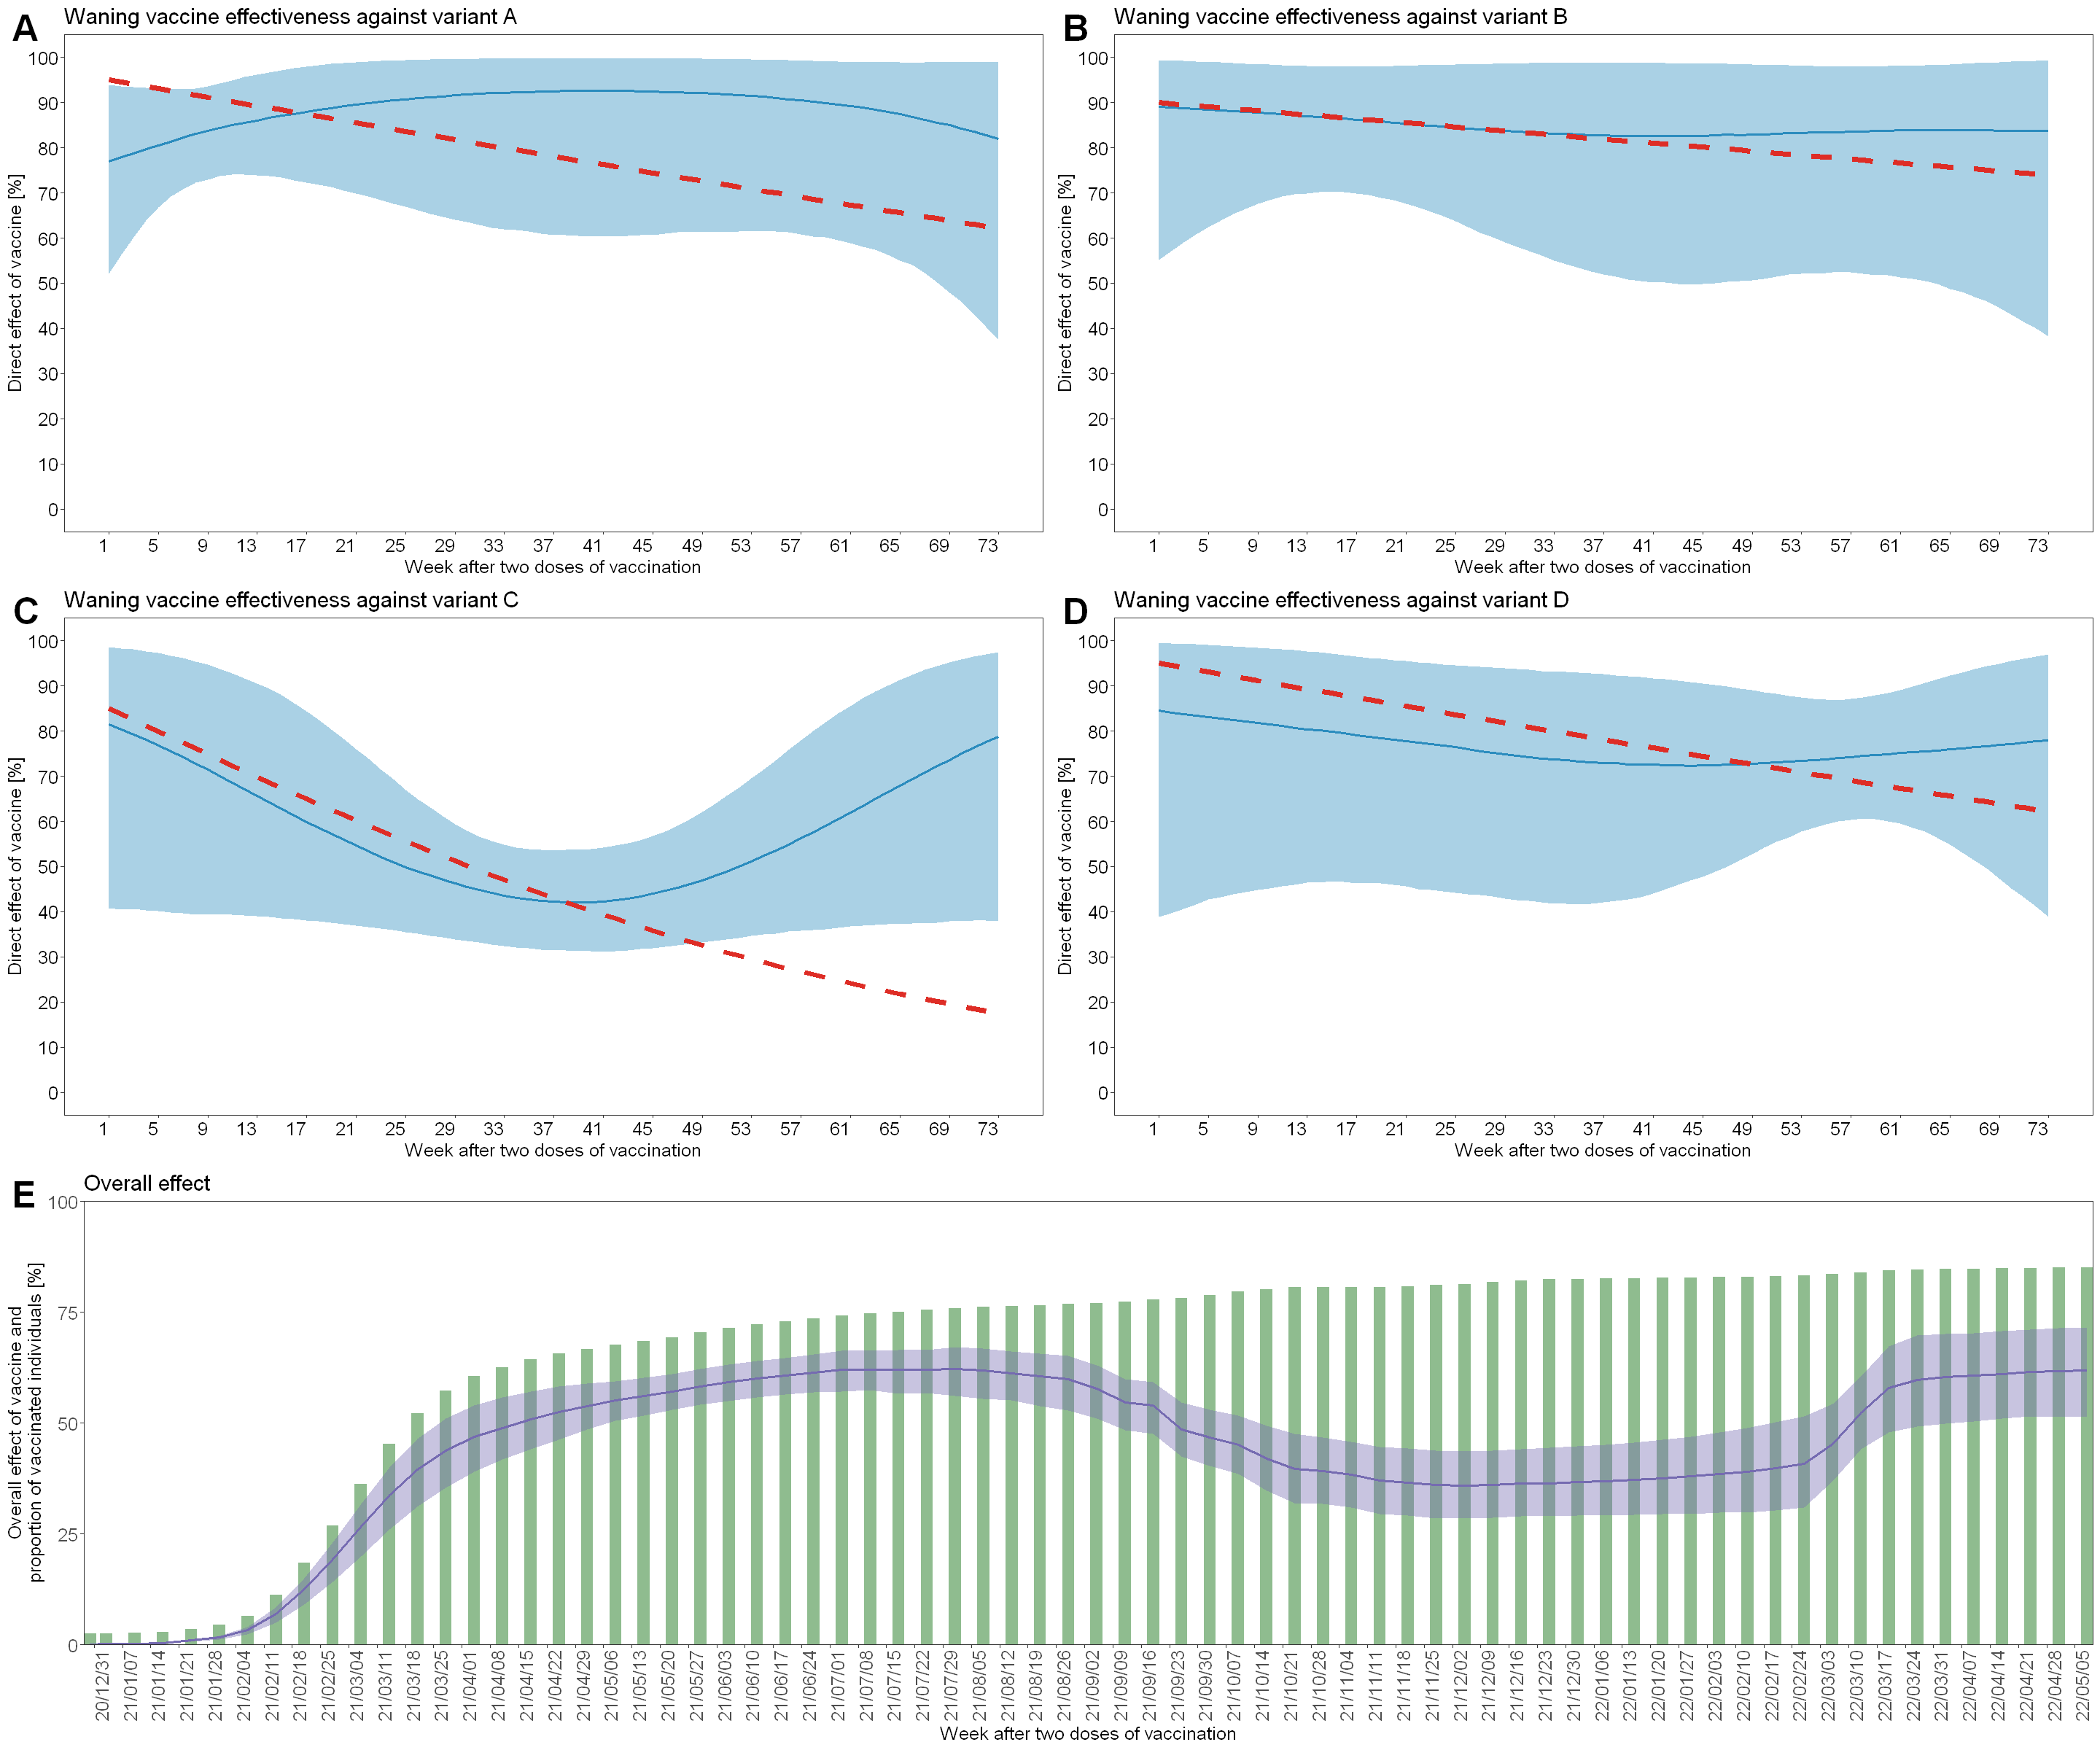

In [45]:
options(repr.plot.width=24,repr.plot.height=20)
direct_effect1 <- ggarrange(delta_plot, omicron_plot, nrow=1,ncol=2,labels=c("C","D"),font.label=list(size=30),common.legend=TRUE,legend="right")
direct_effect2 <- ggarrange(others_plot,alpha_plot, nrow=1,ncol=2,labels=c("A","B"),font.label=list(size=30),common.legend=TRUE,legend="right")
ggarrange(direct_effect2, direct_effect1, overall_plot, nrow=3,ncol=1,font.label=list(size=30),labels=c("","","E"))

ggsave(file = "output/VE_waning_simulation1_spline.png", width = 24, height = 20)